In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

### Conjunto de datos

Se usa el conjunto de datos publicado en el portal de trámites del estado que está en https://datos.gob.bo/dataset/tramites-estado.
El presente conjunto de datos, muestra los trámites de las distintas instituciones del Estado registradas hasta la fecha en el Portal Único de Trámites https://gob.bo.

Se tienen los siguientes objetivos:

- Resumir algunos datos usando gráficos que ayuden a visualizar comportamientos.
- Encontrar reglas de asociación en las categorías a las que pertenecen los trámites.

In [2]:
# Cargando el conjunto de datos
tramites = pd.read_csv('tramites_rev.csv', sep='|')
tramites.shape

(1029, 43)

## Análisis exploratorio de datos

In [3]:
tramites.head()

id_entidad                        denominacion    sigla  codigo  \
0         449                       Pro – Bolivia  PRO-BOL     NaN   
1          32  Ministerio de Educación de Bolivia   MINEDU     NaN   
2          32  Ministerio de Educación de Bolivia   MINEDU     NaN   
3          32  Ministerio de Educación de Bolivia   MINEDU     NaN   
4          32  Ministerio de Educación de Bolivia   MINEDU     NaN   

                                    objetivo_entidad      url_sitio_web  \
0                                                NaN                NaN   
1  Diseñar, implementar y ejecutar políticas, est...  www.minedu.gob.bo   
2  Diseñar, implementar y ejecutar políticas, est...  www.minedu.gob.bo   
3  Diseñar, implementar y ejecutar políticas, est...  www.minedu.gob.bo   
4  Diseñar, implementar y ejecutar políticas, est...  www.minedu.gob.bo   

                            horario_atencion_entidad  \
0  {"segundo": {"hora_ini": "2018-05-31T16:15:14....   
1  {"primero": {"hora_fin": "2017-12-17T16:30:00....   
2  {"primero": {"hora_fin": "2017-12-17T16:30:00....   
3  {"primero": {"hora_fin": "2017-12-17T16:30:00....   
4  {"primero": {"hora_fin": "2017-12-17T16:30:00....   

                               servicios_intercambio  \
0  ["IMPUESTOS NACIONALES, SIGEP,agetic,FUNDEMPRE...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                              mecanismos_seguimiento  \
0  ["CODICE", "Call Center y correo electrónico,S...   
1  ["Centro de Contacto", "Plataforma de Atención...   
2  ["Centro de Contacto", "Plataforma de Atención...   
3  ["Centro de Contacto", "Plataforma de Atención...   
4  ["Centro de Contacto", "Plataforma de Atención...   

                                 mecanismos_atencion  ... tramite_en_linea  \
0  ["LINEA GRATUITA 800101660, Atención al client...  ...                f   
1  ["Plataforma de atención al público", "Línea G...  ...                f   
2  ["Plataforma de atención al público", "Línea G...  ...                f   
3  ["Plataforma de atención al público", "Línea G...  ...                f   
4  ["Plataforma de atención al público", "Línea G...  ...                f   

  tipo_acceso                  duracion_tramite concepto_costo monto_costo  \
0     PUBLICO  {"unidad": "dia", "cantidad": 0}            NaN          90   
1     PUBLICO  {"unidad": "dia", "cantidad": 0}  Certificación         100   
2     PUBLICO  {"unidad": "dia", "cantidad": 0}  Certificación          50   
3     PUBLICO  {"unidad": "dia", "cantidad": 0}            NaN         500   
4     PUBLICO  {"unidad": "dia", "cantidad": 0}  Certificación         100   

  moneda_costo                      cuenta_deposito_costo  \
0           BS                                        NaN   
1           BS                                        NaN   
2           BS                                        NaN   
3           BS  Indicar que es para el trámite solicitado   
4           BS                                        NaN   

                                    descripcion_pago    forma_pago_costo  \
0                                                NaN  Depósito en cuenta   
1                                                NaN            Efectivo   
2  Arancel de la Certificación del Certificado de...            Efectivo   
3  Arancel por la Apertura, funcionamiento y ampl...            Efectivo   
4       Arancel de la Certificación de Carga Horaria            Efectivo   

   descripcion_categoria  
0   Económico-Productivo  
1              Educación  
2              Educación  
3              Educación  
4              Educación  

[5 rows x 43 columns]

In [4]:
# Renombrando columnas para mejorar entendimiento
tramites = tramites.rename(columns={ 'denominacion': 'nombre_entidad', 'descripcion_categoria': 'categoria' })

In [5]:
for col in tramites.columns:
    print(col)

id_entidad
nombre_entidad
sigla
codigo
objetivo_entidad
url_sitio_web
horario_atencion_entidad
servicios_intercambio
mecanismos_seguimiento
mecanismos_atencion
proyectos_simplificacion
experiencia_ciudadana
mae
titulo_tramite
objetivo_tramite
marco_legal
duracion_meses
duracion_dias
duracion_horas
duracion_minutos
palabras_clave
url_tramite_en_linea
url_informacion_tramite
url_aplicacion_movil
ciudadania_digital
empresa_digital
plataforma_pago
firma_digital
horario_atencion_tramite
procedimientos
observacion_tramite
valoracion
apostilla
tramite_en_linea
tipo_acceso
duracion_tramite
concepto_costo
monto_costo
moneda_costo
cuenta_deposito_costo
descripcion_pago
forma_pago_costo
categoria


Se usran las columnas:

* **procedimientos**: Contiene texto con la descripción de los procedimientos de cada trámite, esta en formato HTML y hay que eliminar estas etiquetas y solamente obtener el texto.
* **palabras_clave**: Palabras clave que identifican al trámite
* **categoria**: Son las etiquetas de clasificación del trámite, el trámite pertenece a la categoría listada aquí.
* **nombre_entidad**: Es el nombre de la institución pública a la que pertenece el trámite.

Se harán varios tipos de entrenamiento:

1. Se usará la columna **procedimientos** y como etiqueta clasificadora **categoria**.
2. Se usará la columna **procedimientos** y como etiqueta clasificadora **nombre_entidad**.
3. Se usará la columna **procedimientos** y como etiqueta clasificadora **palabras_clave**.
4. Se van a combinar **procedimientos, palabras_clave, nombre_entidad** y como etiqueta clasificadora **categoria**.

In [6]:
df = tramites[["procedimientos", "palabras_clave", "categoria", "nombre_entidad"]]

In [7]:
df[["procedimientos", "palabras_clave", "categoria", "nombre_entidad"]].dtypes

procedimientos    object
palabras_clave    object
categoria         object
nombre_entidad    object
dtype: object

In [8]:
df["categoria"].value_counts()

Educación               270
Económico-Productivo    197
Gobierno                150
Salud                    93
Cultura y Turismo        74
Identificación           69
Transporte               61
Medio Ambiente           53
Justicia                 50
Bienes Inmuebles          7
Impuestos                 5
Name: categoria, dtype: int64

In [9]:
print("Nombres de entidades en total:", len(df["nombre_entidad"].unique()))
print("Tramites sin nombre de entidad:", df["nombre_entidad"].isnull().sum())

Nombres de entidades en total: 51
Tramites sin nombre de entidad: 0


In [10]:
df['palabras_clave']

0                                                      []
1       ["nomina", "docentes", "certificacion", "nomin...
2       ["vencimiento", "plan de estudio", "plan", "ce...
3       ["carreras", "cambio", "domicilio", "instituto...
4       ["certificacion", "carga horaria", "carga", "h...
                              ...                        
1024    ["Modificación de la marca", "Signos distintiv...
1025    ["institutos", "plan", "plan de estudios", "ce...
1026                                                   []
1027    ["CERTIFICACIÓN PARA MAESTROS", "CERTIFICACION...
1028    ["CERTIFICACIÓN PARA MAESTROS", "CERTIFICACION...
Name: palabras_clave, Length: 1029, dtype: object

In [11]:
import ast
# convertimos la columna palabras_clave a tipo lista ya que ahora cada valor es una cadena que representa una lista
df1 = df['palabras_clave'].apply(lambda x: ast.literal_eval(x))
df = df[["procedimientos", "categoria", "nombre_entidad"]]

In [12]:
df.insert(1, 'palabras_clave', df1)
df

procedimientos  \
0     <p style="text-align: justify;"><span style="f...   
1     <p><span style="font-size: 12pt; color: rgb(51...   
2     <ol><li>Apersonarse a ventanilla de informacio...   
3     <p style="margin-left: 54pt; text-align: justi...   
4     <p><span style="font-size: 12pt; color: rgb(51...   
...                                                 ...   
1024  <ol><li>Realizar los pagos correspondientes en...   
1025  <p><span style="font-size: 12pt; color: rgb(51...   
1026  <p style="margin-left: 0px;"><span style="font...   
1027                                                NaN   
1028                                                NaN   

                                         palabras_clave             categoria  \
0                                                    []  Económico-Productivo   
1     [nomina, docentes, certificacion, nomina de do...             Educación   
2     [vencimiento, plan de estudio, plan, certifica...             Educación   
3     [carreras, cambio, domicilio, institutos, fisc...             Educación   
4        [certificacion, carga horaria, carga, horaria]             Educación   
...                                                 ...                   ...   
1024  [Modificación de la marca, Signos distintivos,...  Económico-Productivo   
1025  [institutos, plan, plan de estudios, certifica...             Educación   
1026                                                 []             Educación   
1027  [CERTIFICACIÓN PARA MAESTROS, CERTIFICACION PA...                 Salud   
1028  [CERTIFICACIÓN PARA MAESTROS, CERTIFICACION PA...             Educación   

                                  nombre_entidad  
0                                  Pro – Bolivia  
1             Ministerio de Educación de Bolivia  
2             Ministerio de Educación de Bolivia  
3             Ministerio de Educación de Bolivia  
4             Ministerio de Educación de Bolivia  
...                                          ...  
1024  Servicio Nacional de Propiedad Intelectual  
1025          Ministerio de Educación de Bolivia  
1026          Ministerio de Educación de Bolivia  
1027                Instituto Geográfico Militar  
1028                Instituto Geográfico Militar  

[1029 rows x 4 columns]

## Columna Procedimientos

Esta columna contiene el texto de los procedimientos o descripción del trámite, pero esta en formato HTML entonces quitaremos las etiquetas HTML

In [13]:
# convirtiendo procedimientos en tipo string
df1 = df['procedimientos'].astype(str)
del df['procedimientos']
df.insert(0, 'procedimientos', df1)
df

procedimientos  \
0     <p style="text-align: justify;"><span style="f...   
1     <p><span style="font-size: 12pt; color: rgb(51...   
2     <ol><li>Apersonarse a ventanilla de informacio...   
3     <p style="margin-left: 54pt; text-align: justi...   
4     <p><span style="font-size: 12pt; color: rgb(51...   
...                                                 ...   
1024  <ol><li>Realizar los pagos correspondientes en...   
1025  <p><span style="font-size: 12pt; color: rgb(51...   
1026  <p style="margin-left: 0px;"><span style="font...   
1027                                                nan   
1028                                                nan   

                                         palabras_clave             categoria  \
0                                                    []  Económico-Productivo   
1     [nomina, docentes, certificacion, nomina de do...             Educación   
2     [vencimiento, plan de estudio, plan, certifica...             Educación   
3     [carreras, cambio, domicilio, institutos, fisc...             Educación   
4        [certificacion, carga horaria, carga, horaria]             Educación   
...                                                 ...                   ...   
1024  [Modificación de la marca, Signos distintivos,...  Económico-Productivo   
1025  [institutos, plan, plan de estudios, certifica...             Educación   
1026                                                 []             Educación   
1027  [CERTIFICACIÓN PARA MAESTROS, CERTIFICACION PA...                 Salud   
1028  [CERTIFICACIÓN PARA MAESTROS, CERTIFICACION PA...             Educación   

                                  nombre_entidad  
0                                  Pro – Bolivia  
1             Ministerio de Educación de Bolivia  
2             Ministerio de Educación de Bolivia  
3             Ministerio de Educación de Bolivia  
4             Ministerio de Educación de Bolivia  
...                                          ...  
1024  Servicio Nacional de Propiedad Intelectual  
1025          Ministerio de Educación de Bolivia  
1026          Ministerio de Educación de Bolivia  
1027                Instituto Geográfico Militar  
1028                Instituto Geográfico Militar  

[1029 rows x 4 columns]

In [14]:
import re

def cleanHTMLTags(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, ' ', raw_html)
    return cleantext
df['procedimientos'] = df['procedimientos'].apply(cleanHTMLTags)

In [15]:
df.head(12)

procedimientos  \
0     Recepciona la solicitud de registro de laUni...   
1     1.        Apersonarse a ventanilla de inform...   
2     Apersonarse a ventanilla de informaciones de...   
3     1.       El interesado presenta nota dirigid...   
4     1.        Apersonarse a ventanilla de inform...   
5     1.        Apersonarse a ventanilla de inform...   
6      1.         Solicitar la emisión del Certifi...   
7     1.        Apersonarse a ventanilla de inform...   
8     1.        Apersonarse a ventanilla de inform...   
9      1.         Solicitar la emisión del Certifi...   
10    1.        Apersonarse a ventanilla de inform...   
11    1.      Solicitar la Rectificación de datos ...   

                                       palabras_clave             categoria  \
0                                                  []  Económico-Productivo   
1   [nomina, docentes, certificacion, nomina de do...             Educación   
2   [vencimiento, plan de estudio, plan, certifica...             Educación   
3   [carreras, cambio, domicilio, institutos, fisc...             Educación   
4      [certificacion, carga horaria, carga, horaria]             Educación   
5   [certificado, vencimiento, planes, estudios, c...             Educación   
6   [profesional, título, revalidación, homologación]             Educación   
7   [certificado, examen de grado, original, fotoc...             Educación   
8   [certificado, universidad, plena, privada, ple...             Educación   
9   [profesional, nivel, superior, medio, institut...             Educación   
10         [vestibulares, certificado, certificación]             Educación   
11  [datos, nacional, actual, profesional, secreta...             Educación   

                        nombre_entidad  
0                        Pro – Bolivia  
1   Ministerio de Educación de Bolivia  
2   Ministerio de Educación de Bolivia  
3   Ministerio de Educación de Bolivia  
4   Ministerio de Educación de Bolivia  
5   Ministerio de Educación de Bolivia  
6   Ministerio de Educación de Bolivia  
7   Ministerio de Educación de Bolivia  
8   Ministerio de Educación de Bolivia  
9   Ministerio de Educación de Bolivia  
10  Ministerio de Educación de Bolivia  
11  Ministerio de Educación de Bolivia

## Construyendo la bolsa de palabras

(ref: https://web.stanford.edu/class/cs124/lec/naivebayes.pdf)

Primero vamos a definir un *tokenizer* para dividir una cadena de texto en una lista de palabras (*tokens*) mediante `nltk.word_tokenize` que también remueve signos de puntuación. (ref: https://pybonacci.org/2015/11/24/como-hacer-analisis-de-sentimiento-en-espanol-2/)

Luego vamos a ignorar las *stop words* como por, con, en, etc que no aportan para diferenciar una categoría de otra. Finalmente se van a estandarizar las palabras transformando cada palabra en su palabra raíz. Por ejemplo las palabras *maravilloso*, *maravilla*, maravillarse* comparten la misma palabra raíz, esta técnica es conocida como *stemming* (ref: http://chuvyr.ru/MT-1968-Lovins.pdf).

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from string import punctuation

# para ignorar signos de puntuacion
non_words = list(punctuation)

stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens =  word_tokenize(text)
    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as E:
        print(E)
        print(text)
        stems = ['']
    return stems

# para ignorar stop words
spanish_stopwords = stopwords.words('spanish')

def removeStopwords(text):
    clean_words = [word.lower() for word in text.split() if word.lower() not in spanish_stopwords]
    return ' '.join(clean_words)

In [17]:
df['procedimientos'] = df['procedimientos'].apply(removeStopwords) # quitando *stopwords*
df['procedimientos']

0       recepciona solicitud registro launidad product...
1       1. apersonarse ventanilla informaciones plataf...
2       apersonarse ventanilla informaciones plataform...
3       1. interesado presenta nota dirigida director ...
4       1. apersonarse ventanilla informaciones plataf...
                              ...                        
1024    realizar pagos correspondientes banco unión. i...
1025    1. apersonarse ventanilla informaciones plataf...
1026    1. apersonarse ventanilla informaciones plataf...
1027                                                  nan
1028                                                  nan
Name: procedimientos, Length: 1029, dtype: object

### Entrenando "procedimientos" y "categoria"

Primero solamente vamos usar la columna "procedimientos" como el texto y "categoria" como la columna con las etiquetas clasificadoras con varios algoritmos.

In [18]:
df1 = df[['procedimientos', 'categoria']]
df1.head()

procedimientos             categoria
0  recepciona solicitud registro launidad product...  Económico-Productivo
1  1. apersonarse ventanilla informaciones plataf...             Educación
2  apersonarse ventanilla informaciones plataform...             Educación
3  1. interesado presenta nota dirigida director ...             Educación
4  1. apersonarse ventanilla informaciones plataf...             Educación

In [19]:
from sklearn.model_selection import train_test_split

# diviendo en train y test
X_train, X_test, y_train, y_test = train_test_split(df1['procedimientos'], df1['categoria'], \
                                                    test_size=0.33, random_state=91)

In [20]:
# construyendo la bolsa de palabras
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    #stop_words = spanish_stopwords
)

#### Algoritmo Naive Bayes

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

# clasificador
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
# construyendo un pipeline para ejecutar todas las etapas
textClf_naiveBayes = Pipeline([('vect', vectorizer),
                               ('tfidf', tfidf_transformer),
                               ('clf', MultinomialNB())])

In [22]:
# Ejecutando el clasificador
fitted_naiveBayes = textClf_naiveBayes.fit(X_train, y_train)

In [23]:
import numpy as np

# generando predicciones
predicted_naiveBayes = textClf_naiveBayes.predict(X_test)

# probando su rendimiento
np.mean(predicted_naiveBayes == y_test)

0.538235294117647

El modelo generado aplicando la técnica *Multinomial Naive Bayes* tiene una precisión de de 53.8%.

#### Usando máquinas de soporte vectorial

Usaremos máquinas de soporte vectorial para generar hiperplanos que separen las clases y así que nos permita clasificar un grupo de palabras según su categoría, para nuestro conjunto de datos tenemos 11 categorías (clases) en que se clasifican todos los trámites por lo que se deberían generar 11 hiperplanos que separen por clases cada descripción de trámite.

Entonces usaremos máquinas de soporte para multiclases, en este caso usaremos el *svm.SVC* de scikit learn sin parámetros de optimización.

In [24]:
from sklearn import svm
textClf= Pipeline([('vect', vectorizer),
                   ('tfidf', tfidf_transformer),
                   ('clf', svm.SVC(kernel='linear'))])
_ = textClf.fit(X_train, y_train)
predicted_svm = textClf.predict(X_test)
np.mean(predicted_svm == y_test)

0.5735294117647058

El modelo generado aplicando la técnica *Supported Vector Machine* con un kernel lineal tiene una precisión de 57.35%.

#### Usando *Linear Support Vector Classification.*

Similar a la máquina de soporte vectorial implementada en scikit learn *SVC con el parámetro kernel='linear', pero con mas flexibilidad (ref: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC), usaremos *Linear Support Vector Classification* sin parámetros de optimización.

In [25]:
textClf = Pipeline([('vect', vectorizer),
                    ('tfidf', tfidf_transformer),
                    ('cls', svm.LinearSVC())])
_ = textClf.fit(X_train, y_train)
predicted_svm = textClf.predict(X_test)
np.mean(predicted_svm == y_test)

0.5558823529411765

Obtenemos una precisión de 55.59% sin haber aplicado parámetros de optimización.

#### Usando distintos hyperparámetros para el entrenamiento con máquinas de soporte vectorial

Los hyperparámetros son parámetros que recibe el algoritmo SCV para ajustar el proceso de entrenamiento de la máquina de soporte vectorial, algunos parámetros relevantes que se pueden ajustar son:

* kernels
* (C) Regularización
* ($\gamma$) gamma para kernels; RBF, polinomial y sigmoidal

Las máquinas de soporte vectorial son capaces de ajustar el hyperplano de separación de clases de forma no lineal aprovechando el *kernel-trick* que dice que los datos que no son linealmente separables en el espacio generado por los atributos de entrada pueden ser linealmente separables en el espacio de atributios que se obtienen a aplcicar un *kernel*.

Existen **varios kernels** por ejemplo:

$
K(\vec{x}_i, \vec{x}_j) = \vec{x}_i \cdot \vec{x}_j \rightarrow lineal \\
K(\vec{x}_i, \vec{x}_j) = exp(-\gamma \lvert\lvert \vec{x}_i \cdot \vec{x}_j \rvert\rvert ^ 2 ) \rightarrow gaussiano \\
K(\vec{x}_i, \vec{x}_j) = exp(-\gamma \lvert\lvert \vec{x}_i \cdot \vec{x}_j \rvert\rvert) \rightarrow exponencial \\
K(\vec{x}_i, \vec{x}_j) = (p + \vec{x}_i \cdot \vec{x}_j) ^ q \rightarrow polinimial\\
K(\vec{x}_i, \vec{x}_j) = (p + \vec{x}_i \cdot \vec{x}_j) ^q exp(-\gamma \lvert\lvert \vec{x}_i \cdot \vec{x}_j \rvert\rvert ^ 2 ) \rightarrow híbrido \\ 
K(\vec{x}_i, \vec{x}_j) = tanh(k\vec{x}_i \cdot \vec{x}_j - \delta) \rightarrow sigmoidal \\
$

Como nuestro caso implica varias clases (varias categorías de trámites) es muy probable que la división requira generar planos no lienales para los cuales los *kernels* polinimiales y RBF (*Radial bassis function* o Gaussiano) podrían ser mas apropiados. Aunque el *kernel RBF* funciona bien en aplicaciones como procesamiento de señales o suvizado de imágenes, no es recomendado para clasificación de texto (ref: https://calculatedcontent.com/2012/02/06/kernels_part_1/).

Otro hyperparámetro que puede usarse para hacer ajustes es el parámetro de regularización **C** que mientras más grande sea, mas permite un error o distancia entre la frontera de decisión pra la clasificación, ajustando este parámetro se pueden obtener hyperplanos que generalicen mejor los hyperplanos de separación entre clases. (ref: https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation)
                                                                                                                                    Scikit learn cuenta con la herramienta *GridSearchCV* que permite seleccionar los mejores parámtros haciendo una serie de pruebas donde se definen el espcio de parámetros que se va a aplicar para el entrenamiento y obtención de modelos.

Finalmente el parámetro $\gamma$ sirve para ajustar el coeficiente del mismo nombre cuando se usan los *kernels* sigmoidal, rbf y polinomial.                                                                                                                                                                                                                                                                                                 

In [26]:
from sklearn.model_selection import GridSearchCV
# definiendo el espacio de parametros para probar
# NOTA: se usa la forma <componente>__<parametro> como nombre de parámetros por usar un pipeline en lugar
# de un estimador único, de otra forma sería solo <parametro>.
grid = {'cls__C': (1, 10, 100), # regularizacion C
        'cls__kernel': ('rbf', 'linear', 'poly'),
        'cls__gamma': [0.1, 0.01, 0.001]}

# definiendo un pipeline con etapas basicas antes de aplicar el algoritmo de entrenamiento
pipeline = Pipeline([
    ('vect', vectorizer),
    ('tfidf', tfidf_transformer),
    ('cls', svm.SVC())])
# usando GridSearchCV para buscar los mejores parámetros
grid_search = GridSearchCV(estimator=pipeline, param_grid=grid, refit = True, verbose = 3, n_jobs=3)

In [27]:
# Ejecutando GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/strymsg/Misc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   43.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed:  3.3min finished


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7fa36b409a70>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('cls', SVC())]),
             n_jobs=3,
             param_grid={'cls__C': (1, 10, 100),
                         'cls__gamma': [0.1, 0.01, 0.001],
                         'cls__kernel': ('rbf', 'linear', 'poly')},
             verbose=3)

In [28]:
# obteniendo los mejores parámetros
# print best parameter after tuning 
print("Mejores parametros", grid_search.best_params_) 
# print how our model looks after hyper-parameter tuning 
print("Mejor Estimador:", grid_search.best_estimator_) 

Mejores parametros {'cls__C': 1, 'cls__gamma': 0.1, 'cls__kernel': 'linear'}
Mejor Estimador: Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fa36b409a70>)),
                ('tfidf', TfidfTransformer()),
                ('cls', SVC(C=1, gamma=0.1, kernel='linear'))])


In [29]:
# con los mejores parámetros ahora se puede hacer una predicción
grid_predictions = grid_search.predict(X_test) 
np.mean(grid_predictions == y_test)

0.5735294117647058

Utilizando *GridSearchCV* se obtienen los mejores parámetros; C = 10, $\gamma$=0.1, kernel = rbf. Y usando estos parámetros se logra una predicción de 57.05%.

#### Usando distintos hyperparámetros para *Linear Support Vector Classification.*

In [30]:
# Probando para linearSVC
grid = {'cls__C': (0.2, 0.5, 0.7),
        'cls__loss': ('hinge', 'squared_hinge'),
        'cls__max_iter': (500, 1000)}

pipeline = Pipeline([
    ('vect', vectorizer),
    ('tfidf', tfidf_transformer),
    ('cls', svm.LinearSVC())])
# usando GridSearchCV para buscar los mejores parámetros
grid_search = GridSearchCV(estimator=pipeline, param_grid=grid, refit = True, verbose = 3, n_jobs=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/strymsg/Misc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   37.4s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:  1.4min finished


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7fa36b409a70>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('cls', LinearSVC())]),
             n_jobs=3,
             param_grid={'cls__C': (0.2, 0.5, 0.7),
                         'cls__loss': ('hinge', 'squared_hinge'),
                         'cls__max_iter': (500, 1000)},
             verbose=3)

In [31]:
# obteniendo los mejores parámetros
print("Mejores parametros", grid_search.best_params_) 
print("Mejor Estimador:", grid_search.best_estimator_) 
# con los mejores parámetros ahora se puede hacer una predicción
grid_predictions = grid_search.predict(X_test) 
np.mean(grid_predictions == y_test)

Mejores parametros {'cls__C': 0.5, 'cls__loss': 'squared_hinge', 'cls__max_iter': 500}
Mejor Estimador: Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fa36b409a70>)),
                ('tfidf', TfidfTransformer()),
                ('cls', LinearSVC(C=0.5, max_iter=500))])


0.5647058823529412

Utilizando *GridSearchCV* se obtienen los mejores parámetros; C = 0.5, loss="squared_hinge", max_iter = 500, y usando estos parámetros se logra una predicción de 56.47%.

## Ensamble de clasificadores (pendiente)

Hemos visto que los diferentes algoritmos de clasificación tienen un comportamiento que depende del conjunto de datos y los parámetros de ajuste que se utilicen y muchas veces no se cuenta con información suficiente para seleccionar el mejor clasificador. Es posible combinar el desempeño de varios clasificadores para a partir de esta combinación obtener un mejor clasificador.

![ensambles](./images/ensambles.png)

###  Bagging

Este algoritmo genera clasificadores de varias muestras y se construye un clasificador para cada muestra, con el resultado se construye un clasificador final C* cuya salida es la clase mayoritaria de los clasificadores.

![bagging](images/DTE_Bagging.png)

Usaremos este método de clasificación para combinar los algoritmos que hemos probado y observar el desempeño del calsificador resultante.

In [33]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

textClf_naiveBayes = Pipeline([('vect', vectorizer),
                               ('tfidf', tfidf_transformer),
                               ('clf', MultinomialNB())])
textClf_svc = Pipeline([('vect', vectorizer),
                        ('tfidf', tfidf_transformer),
                        ('cls', svm.LinearSVC())])
textClf_linearSVC = Pipeline([('vect', vectorizer),
                    ('tfidf', tfidf_transformer),
                    ('cls', svm.LinearSVC())])
estimators = [('nv', textClf_naiveBayes), ('svc', textClf_svc), ('linearScv', textClf_linearSVC)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

clf.fit(X_train, y_train).score(X_test, y_test)

AttributeError: 'CountVectorizer' object has no attribute 'n_features_in_'

## Graficas

In [244]:
df['categoria'].unique()

array(['Económico-Productivo', 'Educación', 'Cultura y Turismo',
       'Identificación', 'Gobierno', 'Salud', 'Transporte',
       'Medio Ambiente', 'Justicia', 'Bienes Inmuebles', 'Impuestos'],
      dtype=object)

In [91]:
# Ejemplo tramite con varias categorias
tramites[tramites['titulo_tramite'] == 'Residencia permanente para ciudadanos y ciudadanas argentinas acuerdo Bilateral Bolivia   Argentina']['descripcion_categoria']

274          Gobierno
275             Salud
276          Justicia
277    Identificación
278         Educación
Name: descripcion_categoria, dtype: object

In [92]:
# Conteo de categorías
tramites['descripcion_categoria'].value_counts()

Educación               270
Económico-Productivo    197
Gobierno                150
Salud                    93
Cultura y Turismo        74
Identificación           69
Transporte               61
Medio Ambiente           53
Justicia                 50
Bienes Inmuebles          7
Impuestos                 5
Name: descripcion_categoria, dtype: int64

In [234]:
grafico = sns.countplot(y='descripcion_categoria', data=tramites, order=tramites['descripcion_categoria'].value_counts().index)
grafico.set_title('Cantidad de tramites por categorias')

Text(0.5, 1.0, 'Cantidad de tramites por categorias')

In [94]:
print(tramites['moneda_costo'].value_counts())
def montoEnBolivianos(monto, moneda):
    # Convirtiendo todos los montos a Bolivianos
    # Bs2,33950  por unidad de UFV (consultado el 14 de Marzo de 2020 en https://www.bcb.gob.bo/?q=servicios/ufv/datos_estadisticos
    ufv_en_bolivianos = 2.33950
    dolar_en_bolivianos = 6.86
    if moneda == 'BS':
        return monto
    if moneda == 'UFV':
        return monto*ufv_en_bolivianos
    if moneda == 'SUS':
        return monto*dolar_en_bolivianos

#print(tramites.apply(lambda fila: montoEnBolivianos(fila['monto_costo'], fila['moneda_costo']), axis=1))
tramites['monto_bs'] = np.vectorize(montoEnBolivianos)(tramites['monto_costo'], tramites['moneda_costo'])

BS     814
UFV    170
SUS     45
Name: moneda_costo, dtype: int64


[Text(0, 0, 'Económico-Productivo'),
 Text(0, 0, 'Educación'),
 Text(0, 0, 'Cultura y Turismo'),
 Text(0, 0, 'Identificación'),
 Text(0, 0, 'Gobierno'),
 Text(0, 0, 'Salud'),
 Text(0, 0, 'Transporte'),
 Text(0, 0, 'Medio Ambiente'),
 Text(0, 0, 'Justicia'),
 Text(0, 0, 'Bienes Inmuebles'),
 Text(0, 0, 'Impuestos')]

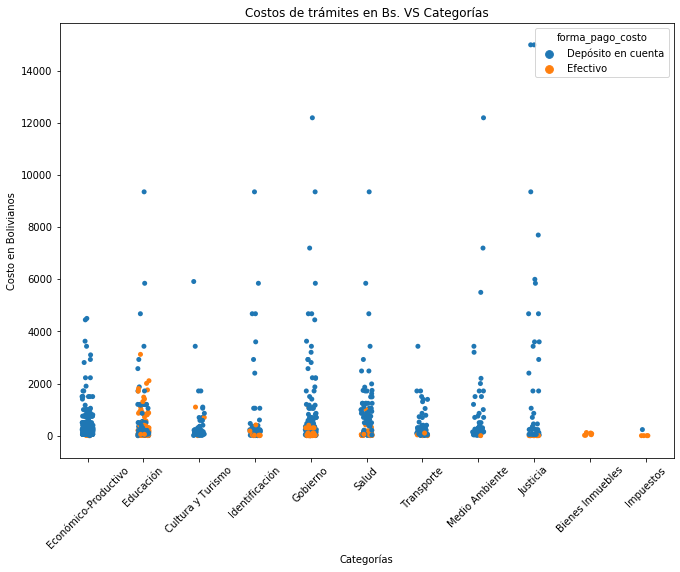

In [145]:
#plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(11, 8))
grafico = sns.stripplot(y='monto_bs', x='descripcion_categoria', hue='forma_pago_costo', data=tramites)
ax.set(xlabel="Categorías", ylabel="Costo en Bolivianos")
grafico.set_title('Costos de trámites en Bs. VS Categorías')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)

El gráfico anterior muestra los montos de pagos en bolivianos de los trámites por categorías y la forma de pago.

In [146]:
fig, ax = plt.subplots(figsize=(11, 8))
grafico = sns.violinplot(y='monto_bs', x='descripcion_categoria', hue='forma_pago_costo', data=tramites,
                         inner=None, color="0.7")
ax.set(xlabel="Categorías", ylabel="Costo en Bolivianos")
grafico.set_title('Distribución de costos en Bolivianos VS categorías')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)

[Text(0, 0, 'Económico-Productivo'),
 Text(0, 0, 'Educación'),
 Text(0, 0, 'Cultura y Turismo'),
 Text(0, 0, 'Identificación'),
 Text(0, 0, 'Gobierno'),
 Text(0, 0, 'Salud'),
 Text(0, 0, 'Transporte'),
 Text(0, 0, 'Medio Ambiente'),
 Text(0, 0, 'Justicia'),
 Text(0, 0, 'Bienes Inmuebles'),
 Text(0, 0, 'Impuestos')]

El gráfico anterior muestra la distribución de montos de pagos por categorías, donde las las partes más ensanchadas denotan una mayor acumulación de cantidad de trámites que tienen un costo similar en bolivianos.

In [35]:
import re
def cleanHTMLTags(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, ' ', raw_html)
    return cleantext
tramites['procedimientos'] = tramites['procedimientos'].astype('str')
# eliminando tags html. solo tomando en cuenta el texto
tramites['procedimientos'] = tramites['procedimientos'].apply(cleanHTMLTags)
tramites['procedimientos']

0         Recepciona la solicitud de registro de laUni...
1         1.        Apersonarse a ventanilla de inform...
2         Apersonarse a ventanilla de informaciones de...
3         1.       El interesado presenta nota dirigid...
4         1.        Apersonarse a ventanilla de inform...
                              ...                        
1024      Realizar los pagos correspondientes en Banco...
1025      1.        Apersonarse a ventanilla de inform...
1026      1.        Apersonarse a ventanilla de inform...
1027                                                  nan
1028                                                  nan
Name: procedimientos, Length: 1029, dtype: object

In [37]:
tramites['procedimientos_len'] = tramites['procedimientos'].apply(len)

In [38]:
tramites['procedimientos_len'].describe()

count    1029.000000
mean      943.033042
std       766.086222
min         3.000000
25%       261.000000
50%       678.000000
75%      1212.000000
max      4193.000000
Name: procedimientos_len, dtype: float64

[Text(0, 0, 'Económico-Productivo'),
 Text(0, 0, 'Educación'),
 Text(0, 0, 'Cultura y Turismo'),
 Text(0, 0, 'Identificación'),
 Text(0, 0, 'Gobierno'),
 Text(0, 0, 'Salud'),
 Text(0, 0, 'Transporte'),
 Text(0, 0, 'Medio Ambiente'),
 Text(0, 0, 'Justicia'),
 Text(0, 0, 'Bienes Inmuebles'),
 Text(0, 0, 'Impuestos')]

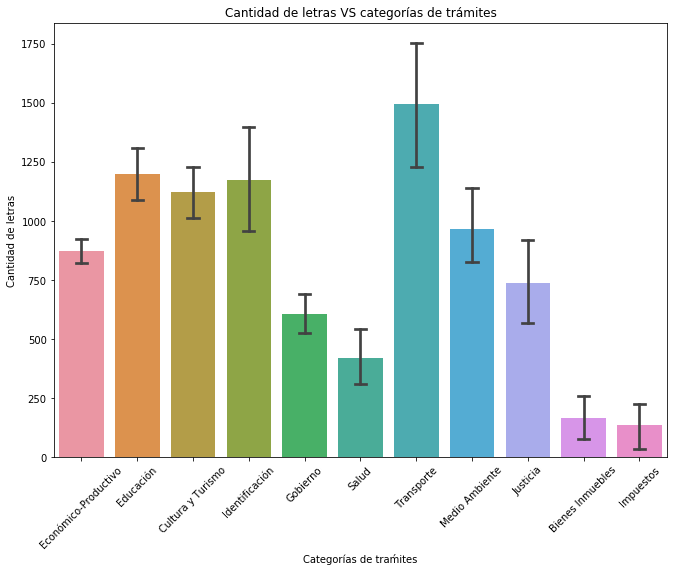

In [161]:
fig, ax = plt.subplots(figsize=(11, 8))
grafico = sns.barplot(y='procedimientos_len', x='descripcion_categoria', ax=ax, data=tramites, capsize=.2)
grafico.set_title('Cantidad de letras VS categorías de trámites')
ax.set(xlabel='Categorías de traḿites', ylabel='Cantidad de letras')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)

En este gráfico muestra por ejemplo que la categoría transporte, los trámites tienen una descripción con una cantidad promedio de letras de casi 1500.

Esto **podría significar** que existe **mucha burocracia** en esta categoría por que posiblemente se requiren muchos pasos para completar el trámite.

(357, 3)
0.0    111
5.0     30
4.0     24
1.0     17
2.0     11
3.0     10
Name: valoracion, dtype: int64


[Text(0, 0, 'Económico-Productivo'),
 Text(0, 0, 'Educación'),
 Text(0, 0, 'Cultura y Turismo'),
 Text(0, 0, 'Identificación'),
 Text(0, 0, 'Gobierno'),
 Text(0, 0, 'Transporte'),
 Text(0, 0, 'Salud'),
 Text(0, 0, 'Medio Ambiente')]

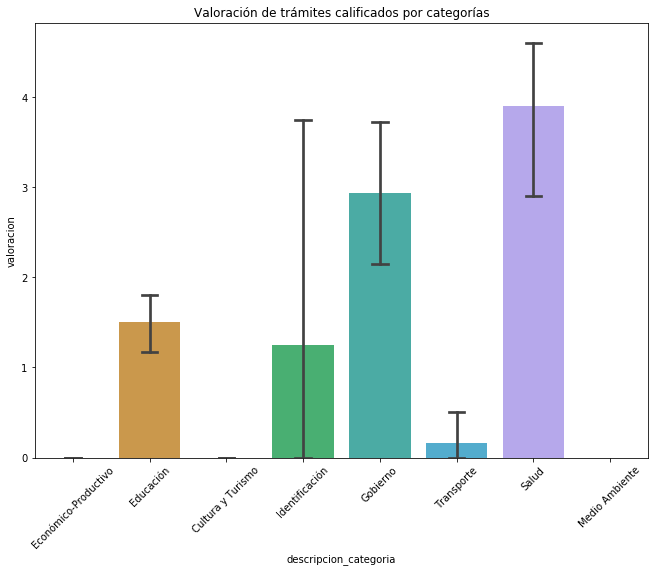

In [233]:
# Ahora analizaremos la valoracion de los tramites por categorias
df_valoracion = tramites[tramites['valoracion'].isna() == False][['descripcion_categoria','titulo_tramite', 'valoracion']]
print(df_valoracion.shape)

# quitando filas repetidas
df_valoracion = df_valoracion.loc[~df_valoracion['titulo_tramite'].duplicated(keep='first')]
print(df_valoracion['valoracion'].value_counts())

fig, ax = plt.subplots(figsize=(11, 8))
grafico = sns.barplot(y='valoracion', x='descripcion_categoria', ax=ax, data=df_valoracion, capsize=.2)
grafico.set_title('Valoración de trámites calificados por categorías')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)